In [3]:
import re
import matplotlib.pyplot as plt
import numpy as np

from compute_features import resize4x, HSV, get_masked_image
from connect_rad_photos import extract_time, get_full_path
from service_defs import find_files

from path import *

In [4]:
cases = [
    "img-2021-08-16T00-45-07devID2.jpg",
    "img-2021-08-13T12-00-04devID1.jpg",
    "img-2021-08-13T12-40-05devID1.jpg",
]

# read all photos
photos = []
for subdir in os.listdir(photos_base_dir):
    if re.findall("snapshots-20[0-9]{2}-[0-9]{2}-[0-9]{2}$", subdir):
        photos.extend(os.listdir(os.path.join(photos_base_dir, subdir)))

photos = pd.DataFrame(photos, columns=["names"])

# extract time and cast to DateTime
photos["time"] = list(extract_time(i) for i in photos["names"])
photos["time"] = pd.to_datetime(photos["time"])

photos["full_path"] = list(get_full_path(i) for i in photos["names"])


# sort DataFrames to apply pd.merge_asof
photos.sort_values(by="time", inplace=True)

In [5]:
def correlation(a, b):
    return np.corrcoef(a, b)[0, 1]

In [6]:
results = {case: pd.DataFrame() for case in cases}

for i, case in enumerate(cases):
    case_time = pd.to_datetime(extract_time(case))
    photos_short = photos[(photos["time"] > (case_time + tolerance / 2)) &
                          (photos["time"] < (case_time + pd.Timedelta("2min")))]
    
    case_img = get_masked_image(get_full_path(case), masks)
    
    result = []
    for k in range(len(photos_short)):
        if photos_short.iloc[k]["names"][-5] == case[-5]:
            # store previous correlation to filter abnormality
            second_image = get_masked_image(photos_short.iloc[k]["full_path"], masks)
            second_time = pd.to_datetime(extract_time(photos_short.iloc[k]["full_path"]))
            # canal 5 because of V from HSV
            current_correlation = correlation(case_img[5], second_image[5])
            to_add = pd.DataFrame([[current_correlation, second_time - case_time]])
            results[case]= pd.concat([results[case], to_add])
            
            print(f"{case}##{k}##{current_correlation}##{i}##", end="\r")
    


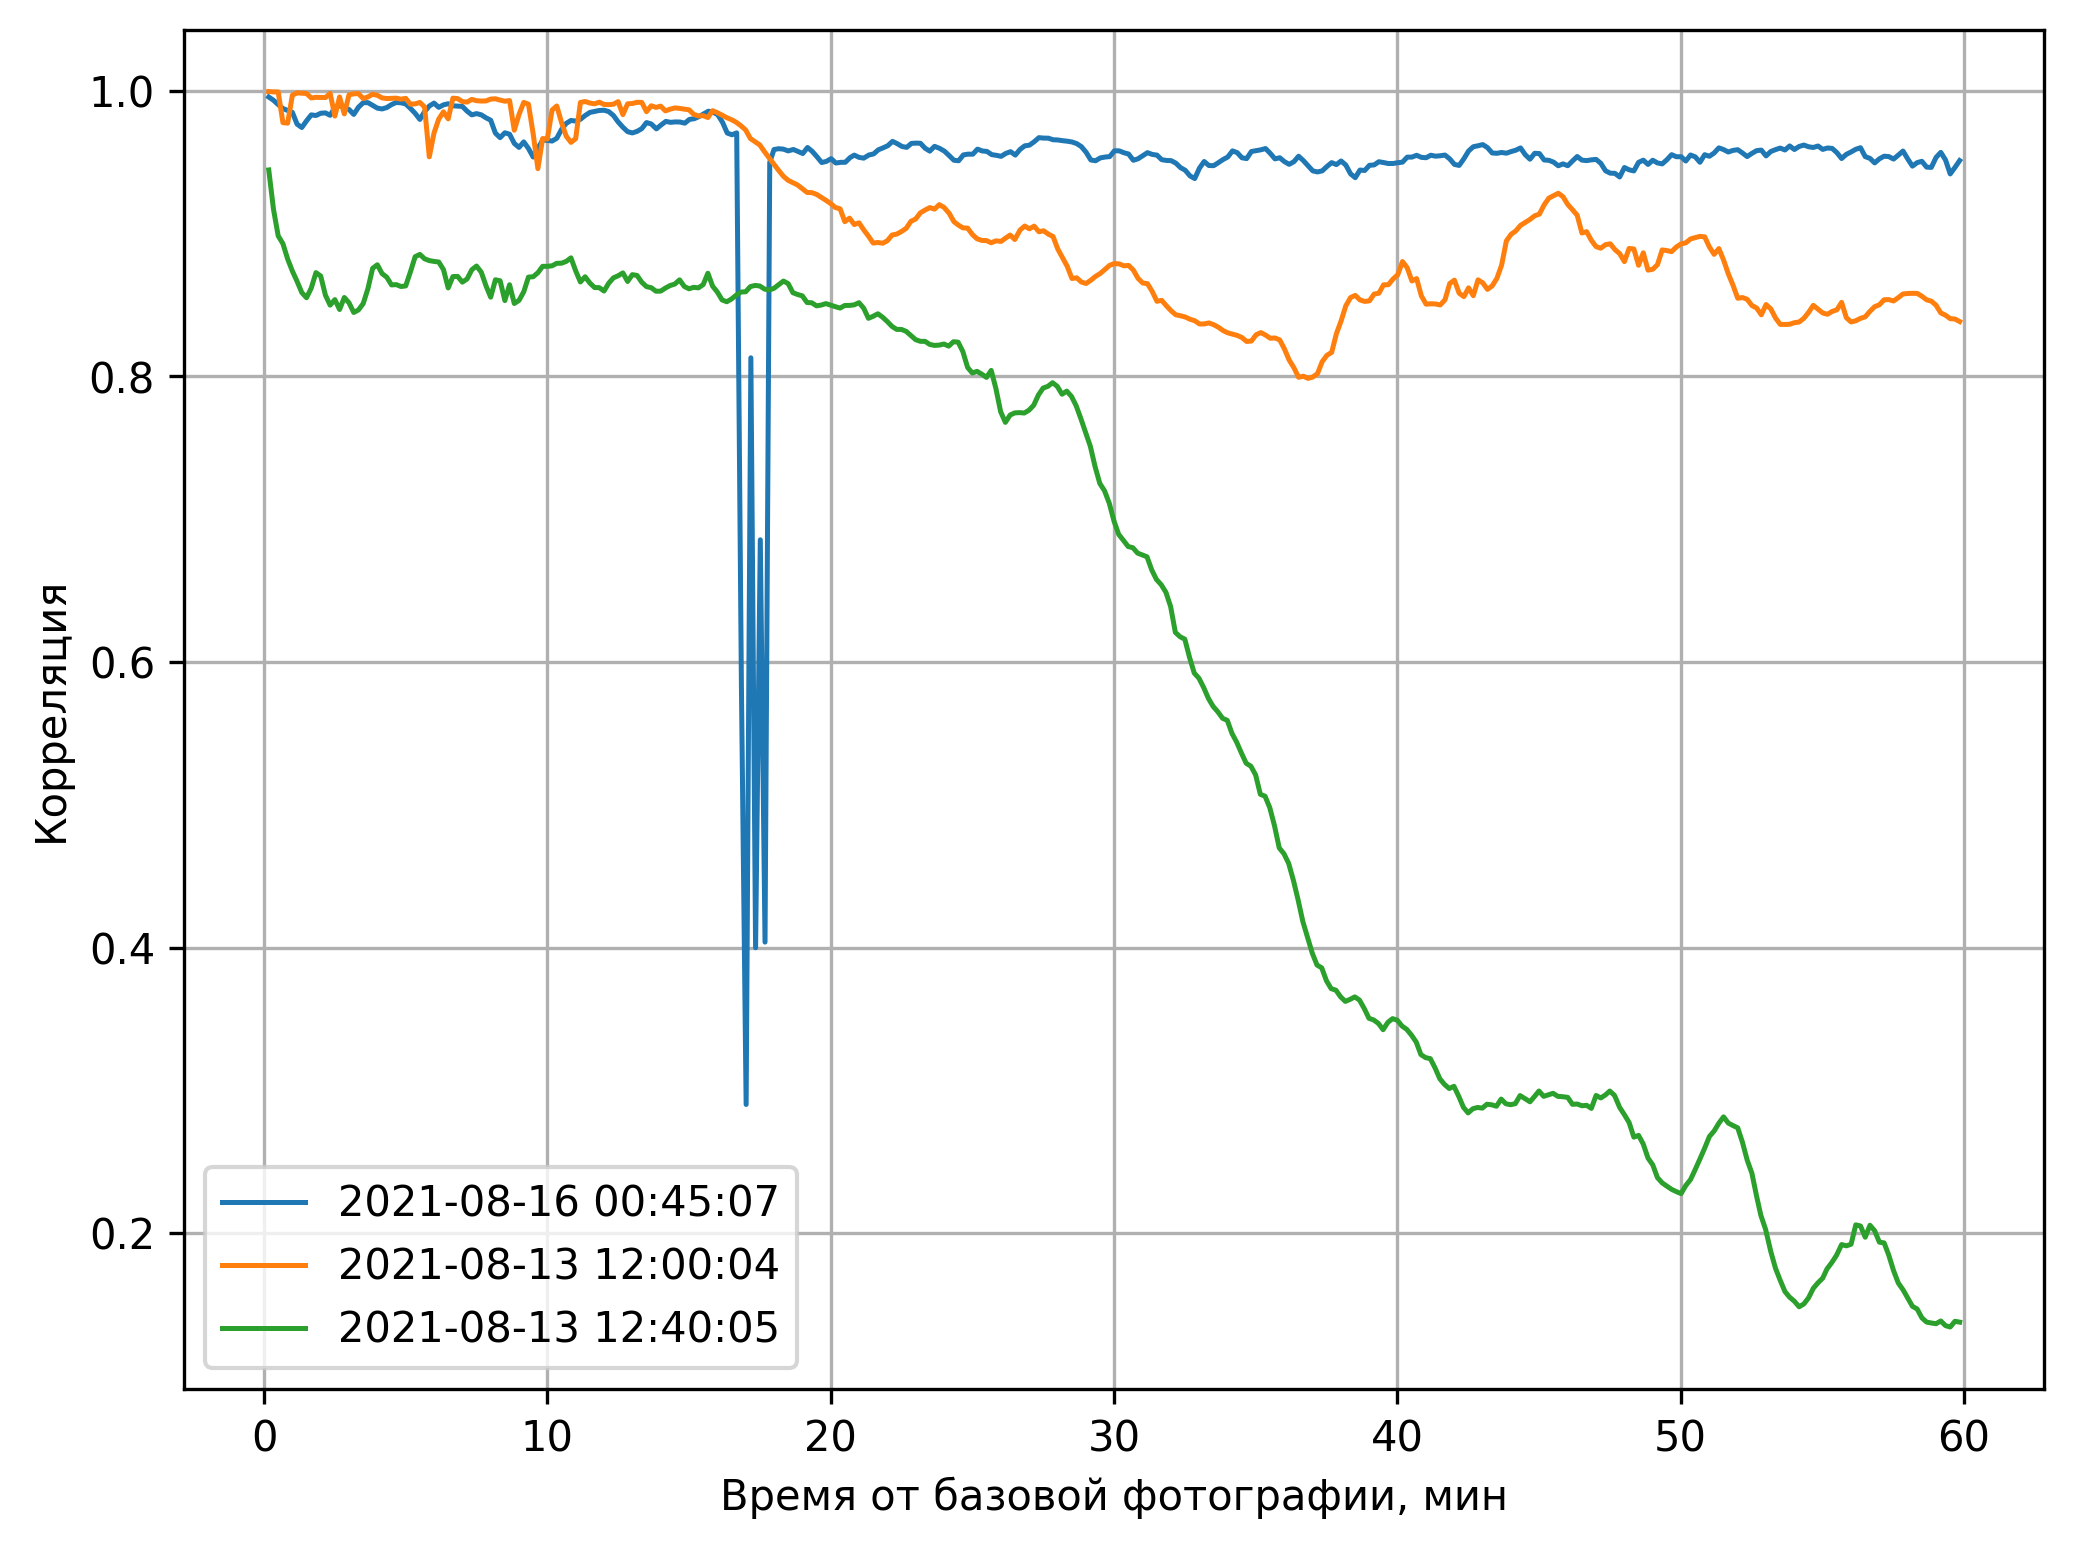

In [7]:
f = plt.figure(figsize=(8, 6), dpi=300)

for case in results:
    plt.plot(results[case][1].values.astype(float) / 1e9 / 60, 
             results[case][0], 
             linewidth=1.2,
             label=extract_time(case),
            )

plt.grid()
plt.legend()
plt.xlabel('Время от базовой фотографии, мин')
plt.ylabel('Корреляция')

plt.savefig("./corr, filter explanation")

KeyError: 1